# Maxwell's Demon , A Stochastic Thermodynamics Approach with a Refrigerator Model 
Maxwell's demon is a thought experiment created by the physicist James Clerk Maxwell in 1867. The demon is a hypothetical intelligent being that can sort molecules in a gas based on their speed, allowing it to create a temperature difference between two regions of the gas without expending any energy. This seems to violate the second law of thermodynamics, which states that the total entropy of a closed system cannot decrease over time.

In this project, we will explore the implications of Maxwell's demon in the context of a refrigerator model, which was proposed by Mandal, Quan, and Jarzynski in their 2013 paper "Maxwell's Refrigerator: An Exactly Solvable Model". The model consists of a two-state system (the demon) that interacts with a stream of bits (the memory) and two heat reservoirs at different temperatures. The demon can flip the state of the bits based on their current state and the temperature of the reservoirs, allowing it to transfer heat from the cold reservoir to the hot reservoir.

We will use stochastic thermodynamics to analyze the behavior of the demon and the refrigerator model, and we will explore how the demon's actions affect the overall entropy of the system. We will also investigate the role of information in the thermodynamics of the system, as the demon's ability to sort molecules is based on its knowledge of their states.

In a stochastic system, the state of the system is described by a probability distribution over its possible states, and the evolution of the system is governed by stochastic processes. These probabilities stem from the transition rates between states, which are influenced by factors such as temperature and energy differences. 

For a two-state system, we can represent the states as "up" (u) and "down" (d). The transition rates between these states can be defined as follows:
- The rates are related to the energy difference (ΔE) between the states and the temperature (T) of the environment where: 
$R_{u \to d}/ R_{d \to u} = e^{-\Delta E / k_B T}$, where $k_B$ is the Boltzmann constant and $T$ is the temperature. $\beta_T = 1/(k_B T)$  can be used for simplification.
- The transition rates can be expressed as:
$R_{u \to d} = \gamma (1 - \sigma)$ ,
$R_{d \to u} = \gamma \sigma$
 where $\sigma = \tanh(\beta_T \Delta E / 2)$

# From Transition Rates to Transition Matrix to Probability Matrix
The transition rates can be used to construct a transition rate matrix (R) for the two-state system:
- $R = \begin{pmatrix} -R_{u \to d} & R_{d \to u} \\ R_{u \to d} & -R_{d \to u} \end{pmatrix}$

The transition rate matrix describes the rates at which the system transitions between states. The diagonal elements are negative, representing the total rate of leaving each state, while the off-diagonal elements represent the rates of transitioning to the other state. This specific matrix is structured such that each column sums to zero, which is a requirement for transition rate matrices. Also this matrix constitutes a continuous-time Markov process. Probability matrix (T) can be obtained by exponentiating the transition rate matrix multiplied by the time interval (τ):
- $T = e^{R \tau}$
The probability matrix describes the probabilities of transitioning between states over the time interval τ. Each element T_{ij} represents the probability of transitioning from state j to state i in time τ. The columns of the probability matrix sum to 1, ensuring that the total probability of transitioning from any given state to all possible states is 1. We can use this probability matrix to find the steady-state distribution of the system but first we will be using it to simulate the trajectory of the system over a series of interactions with bits, bit by bit.

# Definitions and Notations
- Let the demon states be denoted as "u" (up) and "d"
- Let the bit states be denoted as "0" and "1"
- The joint states of the demon and bit can be represented as "u0", "d0", "u1", and "d1"
- The transition rates for the demon interacting with the hot reservoir are denoted as $R_{u \to d}^{(h)}$ and $R_{d \to u}^{(h)}$
- The transition rates for the demon interacting with the cold reservoir are denoted as $R_{u \to d}^{(c)}$ and $R_{d \to u}^{(c)}$
- The transition rates for the bit flipping are denoted as $R_{0 \to 1}$ and $R_{1 \to 0}$
- The combined transition rates for the joint states can be represented in a transition rate matrix (R) and a probability matrix (T)
- Allowed transitions:
    - Intrinsic demon transitions (u <-> d) with no bit flip, interacting with the hot reservoir
    - Cooperative transitions (u0 <-> d1 and d0 <-> u1) with bit flip, interacting with both reservoirs
Then we define R and $\sigma$ as follows:
- $\frac{R_{u \to d}}{R_{d \to u}} = e^{-\beta_h \Delta E}$, where $\beta_h = 1/(k_B T_h)$

- $R_{d \to u} = \gamma (1 - \sigma)$, $R_{u \to d} = \gamma (1 + \sigma)$, where $\sigma = \tanh(\beta_h \Delta E / 2)$

For the bit flips:
- $\frac{R_{0d \to 1u}}{R_{1u \to 0d}} = e^{-\beta_c \Delta E}$, where $\beta_c = 1/(k_B T_c)$
- $R_{0d \to 1u} = 1 - \omega$, $R_{1u \to 0d} =1 + \omega$, where $\omega = \tanh(\beta_c \Delta E / 2)$

We also define $\epsilon = \frac{\omega - \sigma}{1 - \sigma \omega}$, which characterizes the system's bias towards certain transitions based on the temperatures of the reservoirs.


In [49]:
# Parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
kB = 1.0  # Boltzmann constant in our units (energy/temperature)
U0, D0, U1, D1 = 0, 1, 2, 3 # states in rate matrix
T_c = 1.2  # cold bath temperature
T_h = 1.6  # hot bath temperature
DeltaE = 1.0  # energy difference between bit states
gamma = 1.0  # intrinsic transition rate scale
tau = 0.8  # interaction time
p0 = 0.6  # incoming bit probability of 0
N = 100  # number of bits to simulate
seed = 7  # random seed for reproducibility
bias = (2 * p0) - 1  # bias in incoming bits

In [103]:
def sigma_omega_epsilon_from_params(DeltaE, Th, Tc, gamma):
    """Compute the parameters sigma, omega, and epsilon from physical parameters."""
    beta_c = 1.0 / Tc
    beta_h = 1.0 / Th
    sigma = np.tanh(beta_h * DeltaE / 2)
    omega = np.tanh(beta_c * DeltaE / 2)
    epsilon = (omega - sigma) / (1 - sigma * omega)
    return sigma, omega, epsilon
def intrinsic_rates(sigma,gamma):
    """Return Intrinsic transition rates."""
    d_to_u = gamma * (1 - sigma)
    u_to_d = gamma * (1 + sigma)
    return d_to_u, u_to_d
def cooperative_rates(omega):
    """Return Cooperative transition rates."""
    d0_to_u1 = 1 - omega
    u1_to_d0 = 1 + omega
    return d0_to_u1, u1_to_d0
def rate_matrix(sigma, omega, gamma):
    """
    Build the joint rate matrix R for state order [0u, 0d, 1u, 1d].
    R[i,j] is the rate from state j -> i. Columns sum to zero.
    """
    d_to_u, u_to_d = intrinsic_rates(sigma, gamma)
    d0_to_u1, u1_to_d0 = cooperative_rates(omega)
    R = np.zeros((4,4), dtype=float)

    # Intrinsic (hot): 0u <-> 0d
    R[U0, D0] += d_to_u   # 0d -> 0u
    R[D0, U0] += u_to_d   # 0u -> 0d

    # Intrinsic (hot): 1u <-> 1d
    R[U1, D1] += d_to_u   # 1d -> 1u
    R[D1, U1] += u_to_d   # 1u -> 1d

    # Cooperative (cold): 0d <-> 1u
    R[U1, D0] += d0_to_u1  # 0d -> 1u
    R[D0, U1] += u1_to_d0  # 1u -> 0d

    # Diagonals: column-sum zero (probability conservation)
    for j in range(4):
        R[j, j] = -np.sum(R[:, j]) + R[j, j]
    return R
def transition_matrix(R, tau):
    """Compute the transition matrix T = expm(R * tau)."""
    return expm(R * tau)

In [105]:
# Example usage
sigma, omega, epsilon = sigma_omega_epsilon_from_params(DeltaE, T_h, T_c, gamma)
R = rate_matrix(sigma, omega, gamma)
T = transition_matrix(R, tau)
print("Rate matrix R:\n", R)
print("Transition matrix T:\n", T)
print("Epsilon:", epsilon)
# The effect of gamma on the rate matrix is to scale the intrinsic transition rates:
gamma_values = [0.5, 1.0, 5.0]
for g in gamma_values:
    R_gamma = rate_matrix(sigma, omega, g)
    T_gamma = transition_matrix(R_gamma, tau)
    d1_to_u1_prob = T_gamma[D1,U1]  # P(1d -> 1u)
    u0_to_d0_prob = T_gamma[U0,D0]  # P(0u -> 0d)
    print(f"Gamma: {g}, P(1d -> 1u): {d1_to_u1_prob:.4f}")
    print(f"Gamma: {g}, P(0u -> 0d): {u0_to_d0_prob:.4f}")


Rate matrix R:
 [[-1.30270973  0.69729027  0.          0.        ]
 [ 1.30270973 -1.19729027  1.5         0.        ]
 [ 0.          0.5        -2.80270973  0.69729027]
 [ 0.          0.          1.30270973 -0.69729027]]
Transition matrix T:
 [[0.46705241 0.23972518 0.09732632 0.02103418]
 [0.44786559 0.57308408 0.34562324 0.11558916]
 [0.06060983 0.11520775 0.21903136 0.18092858]
 [0.02447217 0.07198299 0.33801909 0.68244808]]
Epsilon: 0.2324767590758143
Gamma: 0.5, P(1d -> 1u): 0.2288
Gamma: 0.5, P(0u -> 0d): 0.1667
Gamma: 1.0, P(1d -> 1u): 0.3380
Gamma: 1.0, P(0u -> 0d): 0.2397
Gamma: 5.0, P(1d -> 1u): 0.4492
Gamma: 5.0, P(0u -> 0d): 0.2897


In [57]:
# We can simulate a trajectory of N bits interacting with the demon using T.
def sample_categorical(probs, rng):
    """Sample from a categorical distribution defined by probs."""
    return rng.choice(len(probs), p=probs)
def normalize(v):
    s = v.sum()
    return v / s if s > 0 else v
STATE_IDX = {"0u": 0, "0d": 1, "1u": 2, "1d": 3}
IDX_TO_BIT_DEMON = {0: (0, "u"), 1: (0, "d"), 2: (1, "u"), 3: (1, "d")}
def simulate_trajectory(
    N=200,
    DeltaE=2.0, Th=2.5, Tc=1.2, gamma=1.0, tau=1.0,
    bit_in=(0.9, 0.1),              # incoming tape distribution (p0, p1)
    demon_init_state="u",           # initial demon state: "u" or "d"
    kB=1.0,
    seed=42
):
    """
    Simulate a single trajectory of N interactions.
    Returns dict with per-bit records and totals.
    """
    rng = np.random.default_rng(seed)
    sigma, omega, epsilon = sigma_omega_epsilon_from_params(DeltaE, Th, Tc, gamma)
    R = rate_matrix(sigma, omega, gamma)
    U = transition_matrix(R, tau)  # transition matrix for one interval

    # Demon initial state
    demon_state = demon_init_state  # "u" or "d"
    
    # Records
    incoming_bits = []
    outgoing_bits = []
    demon_states_in = []
    demon_states_out = []
    bit_flips = []   # True if bit changed 0->1 or 1->0 (model only allows 0d<->1u)
    
    # Counts relevant for heat in this model (0->1 at end = +ΔE from cold)
    count_0_to_1 = 0
    count_1_to_0 = 0
    print(U)
    for _ in range(N):
        # Sample incoming bit from tape
        b_in = 0 if rng.random() < bit_in[0] else 1
        
        # Initial joint basis index by (bit, demon)
        if b_in == 0 and demon_state == "u":
            idx0 = STATE_IDX["0u"]
        elif b_in == 0 and demon_state == "d":
            idx0 = STATE_IDX["0d"]
        elif b_in == 1 and demon_state == "u":
            idx0 = STATE_IDX["1u"]
        else:
            idx0 = STATE_IDX["1d"]
        
        # Final joint distribution after one interval: column of U
        # (U @ e_idx0) is just U[:, idx0]
        probs_final = U[:, idx0]
        idx_tau = sample_categorical(probs_final, rng)
        
        # Decode final states
        b_out, demon_out = IDX_TO_BIT_DEMON[idx_tau]
        
        # Record
        incoming_bits.append(b_in)
        outgoing_bits.append(b_out)
        demon_states_in.append(demon_state)
        demon_states_out.append(demon_out)
        
        # Flip check (model only allows 0d<->1u; but end-to-end flip is enough to count)
        flipped = (b_out != b_in)
        bit_flips.append(flipped)
        if b_in == 0 and b_out == 1:
            count_0_to_1 += 1
        elif b_in == 1 and b_out == 0:
            count_1_to_0 += 1
        
        # Demon becomes initial demon for next interval
        demon_state = demon_out

    # Heat tally: per paper, Q_c->h per interaction is ΔE * (fraction of bits that end as 1 minus start p1)
    # For a trajectory-based **count**, using net 0->1 counts is natural:
    Q_c_to_h_total = (count_0_to_1 - count_1_to_0) * DeltaE  # net energy from cold to hot over N interactions

    return {
        "incoming_bits": np.array(incoming_bits),
        "outgoing_bits": np.array(outgoing_bits),
        "demon_in": np.array(demon_states_in, dtype=object),
        "demon_out": np.array(demon_states_out, dtype=object),
        "bit_flips": np.array(bit_flips, dtype=bool),
        "epsilon": epsilon,
        "sigma": sigma,
        "omega": omega,
        "counts": {
            "N": N,
            "0->1": int(count_0_to_1),
            "1->0": int(count_1_to_0),
            "net_0->1": int(count_0_to_1 - count_1_to_0),
        },
        "Q_c->h_total": Q_c_to_h_total,
    }
    
# Example usage
result = simulate_trajectory(
    N=200,
    DeltaE=2.0, Th=2.5, Tc=1.2, gamma=1.0, tau=1.0,
    bit_in=(0.95, 0.05),              # incoming tape distribution (p0, p1)
    demon_init_state="u",           # initial demon state: "u" or "d"
    kB=1.0,
    seed=42
)
print("Counts:", result["counts"])
print("Total Q_c->h:", result["Q_c->h_total"])
print("Epsilon:", result["epsilon"])
print("Sigma:", result["sigma"])
print("Omega:", result["omega"])



[[0.66745853 0.33917381 0.06354483 0.02710139]
 [0.15240062 0.14467284 0.075642   0.04862088]
 [0.15117111 0.40048584 0.62129757 0.53305176]
 [0.02896974 0.11566751 0.23951559 0.39122597]]
Counts: {'N': 200, '0->1': 52, '1->0': 0, 'net_0->1': 52}
Total Q_c->h: 104.0
Epsilon: 0.4081032552343249
Sigma: 0.3799489622552249
Omega: 0.6822617902381697


In [170]:
# Iterative approach to find periodic steady state
def steady_demon_via_iteration(T, tol=1e-12, maxit=100000):
    """ Find the steady state demon distribution via iteration.
    Returns the steady state demon marginal as a length-2 array [p_u, p_d].
    """
    p = np.array([0.5, 0.5], dtype=float)
    for _ in range(maxit):
        p_next = T @ p
        s = p_next.sum()
        if s <= 0:
            raise RuntimeError("T produced non-positive vector; check R/M/PD.")
        p_next /= s
        if np.linalg.norm(p_next - p, 1) < tol:
            return p_next
        p = p_next
    raise RuntimeError("Steady state iteration did not converge.")

# PD projects joint end -> demon end (2x4)
PD = np.array([
        [1, 0, 1, 0],  # pu = u0 + u1
        [0, 1, 0, 1],  # pd = d0 + d1
    ], dtype=float)

# PB projects joint end -> bit end (2x4)
PB = np.array([
    [1, 1, 0, 0],  # p0 = u0 + d0
    [0, 0, 1, 1],  # p1 = u1 + d1
], dtype=float)
def build_M(p0):
    """Build the M matrix mapping demon start -> joint start (uncorrelated with bit).
    p0 is the probability of incoming bit 0.
    """
    p1 = 1 - p0
    M = np.array([
        [p0, 0.0],   # u0 from demon u
        [0.0, p0],   # d0 from demon d
        [p1, 0.0],   # u1 from demon u
        [0.0, p1],   # d1 from demon d
    ], dtype=float)
    return M
def get_T_c_From_Omega(omega,k_B=1.0,DeltaE=1.0):
    """Compute cold bath temperature T_c from omega."""
    if abs(omega) >= 1:
        raise ValueError("Omega must be in (-1, 1) to compute T_c.")
    beta_c = (2/(DeltaE)) * np.arctanh(omega)  # since k_B=1 in our units
    T_c = 1 / (k_B * beta_c)
    return T_c  
def get_S_delta(inp):
    """Compute the information entropy S(delta) of a bit stream with bias delta."""
    if abs(inp) > 1:
        raise ValueError("Delta must be in [-1, 1].")
    p0 = (1 + inp) / 2
    p1 = (1 - inp) / 2
    S = 0.0
    if p0 > 0:
        S -= p0 * np.log(p0)
    if p1 > 0:
        S -= p1 * np.log(p1)
    return S
def deterministic_solution(gamma, sigma, omega, tau, p0):
    """Compute the deterministic solution for given parameters.
        Given parameters and incoming bit bias delta = p0 - p1,
    compute:
      - steady demon distribution at interval start,
      - outgoing bit distribution,
      - Phi (net production of 1s per bit),
      - Q_{c->h} per bit (in units of DeltaE; you can multiply later),
      - T matrix (2x2) mapping demon start -> demon end,
      - P_tau = exp(R*tau) for reuse.
    """
    p1 = 1 - p0
    assert 0 <= p0 <= 1 and 0 <= p1 <= 1, "p0 must be in [0,1]"
    delta = p0 - p1
    assert -1 <= delta <= 1, "delta must be in [-1,1]"
    assert  0 <= omega <= 1, "sigma and omega must be in [0,1]"
    R = rate_matrix(sigma, omega, gamma)
    P_tau = transition_matrix(R, tau)
    M = build_M(p0)
    T = PD @ (P_tau @ M)
    pD_start = steady_demon_via_iteration(T)
    p_joint_start = M @ pD_start          # 4,
    p_joint_end = P_tau @ p_joint_start   # 4,
    pB_out = PB @ p_joint_end             # 2,
    pB_out = normalize(pB_out)

    # Phi = p1_out - p1_in
    Phi = pB_out[1] - p1
    # Delta S = S(delta_out) - S(delta_in)

    S_in = get_S_delta(delta)
    S_out = get_S_delta(delta - 2 * Phi)
    DeltaS = S_out - S_in

    # Heat per bit in units of DeltaE: Q_c->h = Phi * DeltaE  (we return Phi only)
    return {
        "pD_start": pD_start,       # [pu, pd]
        "pB_out": pB_out, # [p0_out, p1_out]
        "epsilon": (omega - sigma) / (1 - sigma * omega),
        "Phi": Phi,
        "DeltaS": DeltaS,
        "T": T,
        "P_tau": P_tau,
        "R": R,
        "p_in": np.array([p0, p1]),
    }

In [66]:
# Now we can move on to getting phi by getting the steady state distribution.

gamma = 1.0  # intrinsic transition rate scale
tau = 0.8  # interaction time
p0 = 0.95  # incoming bit probability of 0
T_c = 1.2  # cold bath temperature
T_h = 1.6  # hot bath temperature
DeltaE = 1.0  # energy difference between bit states
sigma, omega, epsilon = sigma_omega_epsilon_from_params(DeltaE, T_h, T_c, gamma)
dict_result = deterministic_solution(gamma, sigma, omega, tau, p0)
print("Steady demon distribution at start:", dict_result["pD_start"])
print("Incoming bit distribution:",[p0, 1-p0])
print("Outgoing bit distribution:", dict_result["pB_out"])
print("Phi (net production of 1s per bit):", dict_result["Phi"])    


Steady demon distribution at start: [0.75375032 0.24624968]
Incoming bit distribution: [0.95, 0.050000000000000044]
Outgoing bit distribution: [0.77327552 0.22672448]
Phi (net production of 1s per bit): 0.17672448454767026


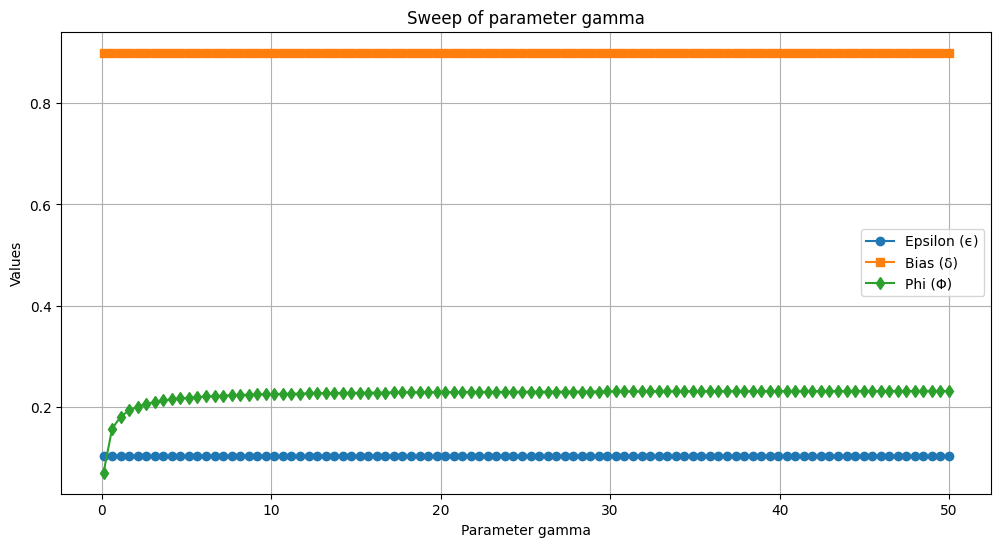

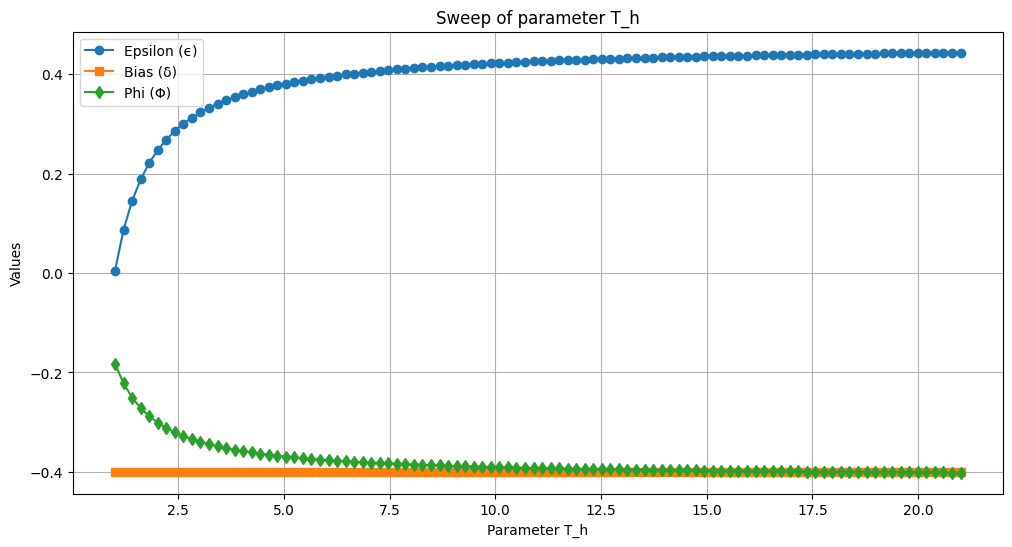

In [ ]:

def sweep_parameter_for_correlation(
    gamma = np.array([1.0]),
    T_c = np.array([1.2]),
    T_h = np.array([1.6]),
    p_0 = np.array([0.95]),
    tau = np.array([1.0]),
    DeltaE = np.array([1.0]),
    param_Title = ""
):
    assert  0 < len(param_Title), "provide a single character for param_Title"
    all_params = {
        'g': gamma,
        'c': T_c,
        'h': T_h,
        'p': p_0,
        't': tau,
        'd': DeltaE
    }
    assert param_Title in all_params, "param_Title must be one of " + str(list(all_params.keys()))
    sweep_values = all_params[param_Title]
    fixed_params = {k: v[0] for k, v in all_params.items() if k != param_Title}
    results = []
    for val in sweep_values:
        params = fixed_params.copy()
        params[param_Title] = val
        gamma_val = params['g']
        T_c_val = params['c']
        T_h_val = params['h']
        p0_val = params['p']
        tau_val = params['t']
        DeltaE_val = params['d']
        sigma, omega, epsilon = sigma_omega_epsilon_from_params(DeltaE_val, T_h_val, T_c_val, gamma_val)
        dict_result = deterministic_solution(gamma_val, sigma, omega, tau_val, p0_val)
        results.append({
            'param_value': val,
            'epsilon': epsilon,
            'sigma': sigma,
            'omega': omega,
            'pD_start': dict_result['pD_start'],
            'pB_out': dict_result['pB_out'],
            'Phi': dict_result['Phi'],
            'T': dict_result['T'],
            'P_tau': dict_result['P_tau'],
            'R': dict_result['R'],
            'p_in': dict_result['p_in'],
        })
    return results

def plot_sweep_results(results, param_Title):
    all_params = {
        'g': "gamma",
        'c': "T_c",
        'h': "T_h",
        'p': "p_0",
        't': "tau",
        'd': "DeltaE"
    }
    param_values = [res['param_value'] for res in results]
    epsilons = [res['epsilon'] for res in results]
    sigmas = [res['sigma'] for res in results]
    omegas = [res['omega'] for res in results]
    phi_values = [res['Phi'] for res in results]
    bias_values = [res['p_in'][0] - res['p_in'][1] for res in results]
    plt.figure(figsize=(12, 6))
    plt.plot(param_values, epsilons, label='Epsilon (ϵ)', marker='o')
    plt.plot(param_values, bias_values, label='Bias (δ)', marker='s')
    plt.plot(param_values, phi_values, label='Phi (Φ)', marker='d')
    plt.xlabel(f'Parameter {all_params[param_Title]}')
    plt.ylabel('Values')
    plt.title(f'Sweep of parameter {all_params[param_Title]}')
    plt.legend()
    plt.grid(True)
    plt.show()
# Example usage:
gamma_values = np.linspace(0.1, 50.0, 100)
results = sweep_parameter_for_correlation(
    gamma=gamma_values, param_Title='g'
)
plot_sweep_results(results, 'g')
T_c = 1.0
T_H_values = np.linspace(T_c+0.01, T_c+20.0, 100)
results = sweep_parameter_for_correlation(
    T_c=np.array([T_c]), param_Title='h', T_h=T_H_values, p_0=np.array([0.3]), tau=np.array([5.0])
)
plot_sweep_results(results, 'h')

Points where ΔS=0: 279


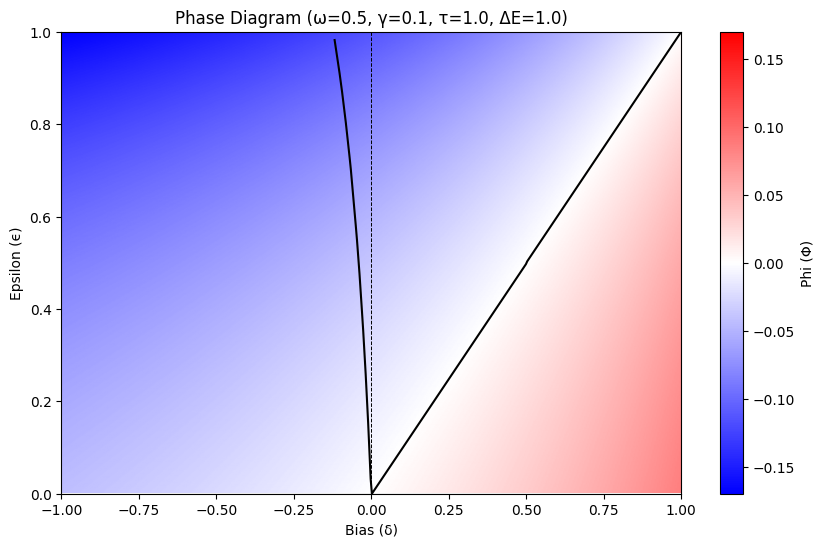

Points where ΔS=0: 358


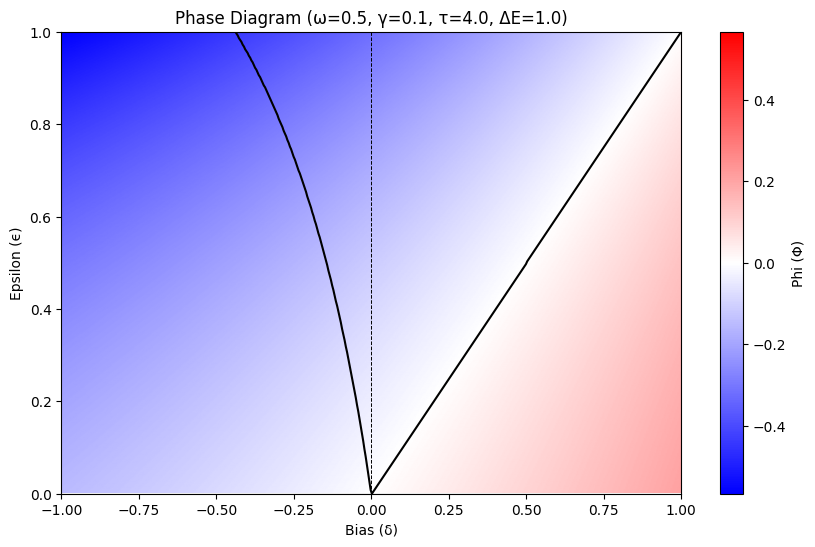

Points where ΔS=0: 450


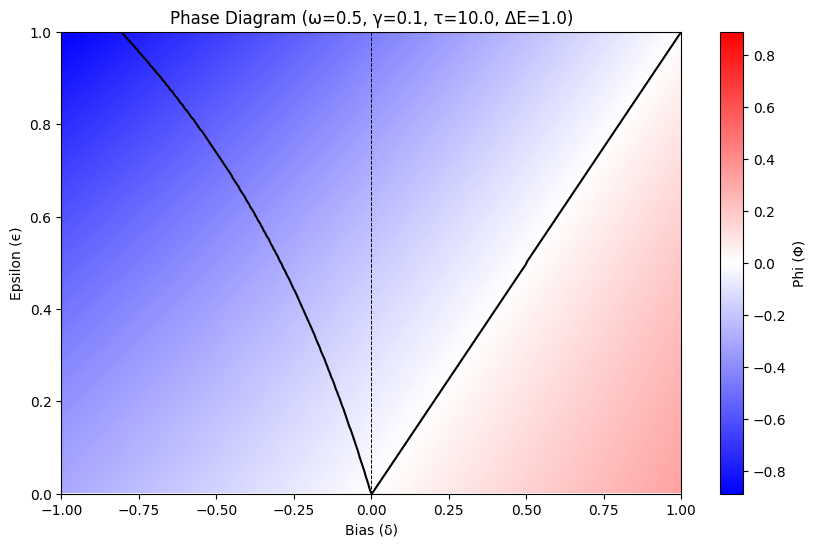

In [235]:
def get_T_h_from_epsilon(epsilon, omega, deltaE=1.0, kB=1.0):
    """Compute hot bath temperature T_h from epsilon and omega."""
    if abs(omega) >= 1 or abs(epsilon) >= 1:
        raise ValueError("Omega and epsilon must be in (-1, 1) to compute T_h.")
    sigma = (omega - epsilon) / (1 - epsilon * omega)
    if abs(sigma) >= 1:
        raise ValueError("Computed sigma is out of bounds; invalid parameters.")
    beta_c = (2/(deltaE)) * np.arctanh(omega)  # since k_B=1 in our units
    beta_h = (2/(deltaE)) * np.arctanh(sigma)  # since k_B=1 in our units
    
    # if(beta_h <= 0):
    #     print("beta_h:", beta_h)
    #     print("beta_c:", beta_c)
    #     print("Invalid parameters: epsilon =", epsilon, ", omega =", omega)
    #     print("Arctanh(epsilon):", np.arctanh(epsilon))
    T_h = 1 / (kB * beta_h)
    return T_h
def build_phase_diagram( gamma =1.0 , omega = 0.5, deltaE =4.0,tau=1.0):
    bias_values = np.linspace(-1, 1, 500)
    epsilon_values = np.linspace(0, 1, 500)
    Phi_matrix = np.zeros((len(bias_values), len(epsilon_values)))
    xs, ys = [], []
    DeltaS_values = np.zeros((len(bias_values), len(epsilon_values)))

    for i, delta in enumerate(bias_values):
        p0 = (delta + 1) / 2
        
        for j, epsilon in enumerate(epsilon_values):
            try:
                T_h = get_T_h_from_epsilon(epsilon, omega, deltaE=deltaE)
                T_c = get_T_c_From_Omega(omega, DeltaE=deltaE)
                sigma, _, epsilon2 = sigma_omega_epsilon_from_params(deltaE, T_h, T_c, gamma)
                # print(f"Computing Phi for delta={delta:.2f}, epsilon={epsilon2:.2f}, T_h={T_h:.2f}, T_c={T_c:.2f}, sigma={sigma:.2f}, omega={omega:.2f}")
                dict_result = deterministic_solution(gamma, sigma, omega, tau=tau, p0=p0)
                DeltaS_values[i, j] = dict_result["DeltaS"]
                # DeltaS = dict_result["DeltaS"]
                # tol = 1e-5
                # if(DeltaS == 0 or np.abs(DeltaS) <tol):
                #     xs.append(delta)
                #     ys.append(epsilon)
                Phi_matrix[len(bias_values)-j-1, i] = dict_result['Phi']
            except ValueError:
                Phi_matrix[j, i] = np.nan  # Invalid parameters
    for i in range(len(bias_values)-1):
        row = DeltaS_values[i,:]
        for j in range(len(bias_values) - 1):

            if (row[j] * row[j + 1] < 0 ):
                xs.append(bias_values[i])
                ys.append(epsilon_values[j])
            # elif (np.abs(row[j + 1]) == 0):
            #     xs.append(bias_values[i])
            #     ys.append(epsilon_values[j + 1])

    # Plotting
    plt.figure(figsize=(10, 6))
    # Set colormap to be white at 0
    max_phi = np.nanmax(np.abs(Phi_matrix))
    plt.imshow(Phi_matrix, extent=[-1, 1, 0, 1], cmap='bwr', aspect='auto')
    plt.clim(-max_phi, max_phi)
    plt.colorbar(label='Phi (Φ)')
    plt.plot(xs, ys, color="black",label='ΔS = 0')
    print(f"Points where ΔS=0: {len(xs)}")
    plt.ylabel('Epsilon (ϵ)')
    plt.xlabel('Bias (δ)')
    plt.title(f'Phase Diagram (ω={omega}, γ={gamma}, τ={tau}, ΔE={deltaE})')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
    plt.show()
# Example usage:
build_phase_diagram(gamma=0.1, omega=0.5, deltaE=1.0,tau=1.0)
build_phase_diagram(gamma=0.1, omega=0.5, deltaE=1.0,tau=4.0)
build_phase_diagram(gamma=0.1, omega=0.5, deltaE=1.0,tau=10.0)

        

Points where ΔS=0: 240


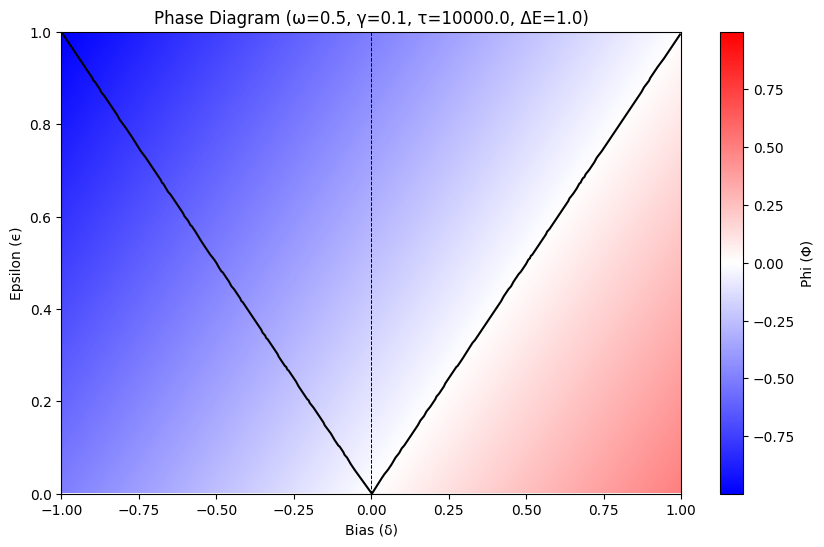

In [236]:
build_phase_diagram(gamma=0.1, omega=0.5, deltaE=1.0,tau=10000.0)


Points where ΔS=0: 279


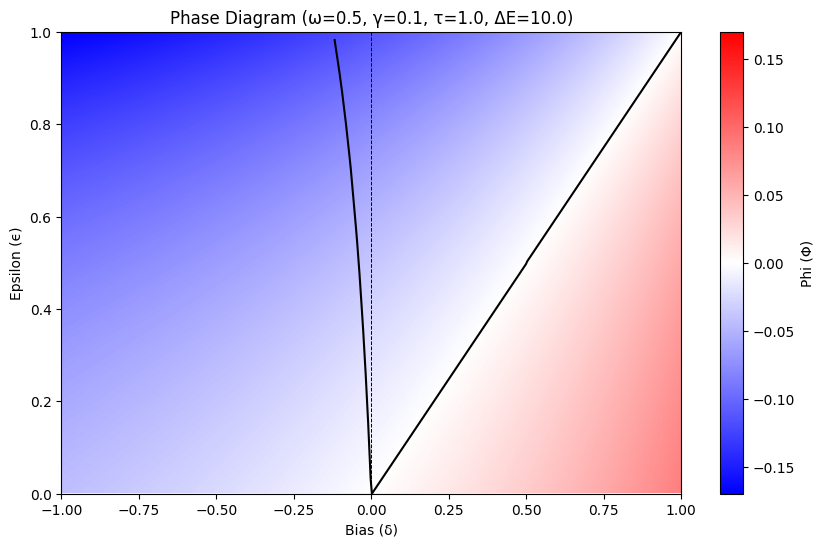

In [237]:
build_phase_diagram(gamma=0.1, omega=0.5, deltaE=10.0,tau=1.0)
